# Ensembles and Random Forests
### `! git clone https://github.com/ds3001f25/ensembles_random_forests.git`

In [1]:
import pandas as pd
import numpy as np
from sklearn import tree
import seaborn as sns
import matplotlib.pyplot as plt

## Back to Machine Learning
- The point of the probability/bootstrap lectures was to introduce the idea and power of resampling
- Your data aren't just one set of data: They're a deep reservoir of information that can be used to quantify all kinds of uncertainty
- Can these principles be applied directly to solving machine learning problems? (Today is one version of an answer to that question)

## Decision Trees
- Let's look at the housing price data again, where we predict `sale_price` from a bunch of features of the property
- The original model looks fine: It uses a number of square footage variables, which seems reasonable, and drops the rest of the variables.
- What happens if we resample the data 10 times, and build new decision trees on the new bootstrapped data sets?

In [2]:
df = pd.read_csv('./data/pierce_county_house_sales.csv')

df['age'] = max(df['year_built'])-df['year_built']

vars = ["attached_garage_square_feet","attic_finished_square_feet","basement_square_feet","bathrooms",
          "bedrooms","detached_garage_square_feet","fireplaces","house_square_feet",
          "sale_price","stories","age"]

df = df.loc[:,vars]
df.head()

,attached_garage_square_feet,attic_finished_square_feet,basement_square_feet,bathrooms,bedrooms,detached_garage_square_feet,fireplaces,house_square_feet,sale_price,stories,age
0,528,0,0,3,3,0,0,2157,380000,2,28
1,396,0,0,3,4,0,0,2238,383000,2,4
2,0,0,0,2,3,0,1,1452,419900,1,56
3,0,0,0,1,2,0,0,832,251660,1,102
4,484,0,384,2,3,0,1,1780,500000,1,66


In [3]:
df.describe()

,attached_garage_square_feet,attic_finished_square_feet,basement_square_feet,bathrooms,bedrooms,detached_garage_square_feet,fireplaces,house_square_feet,sale_price,stories,age
count,16814.000000,16814.000000,16814.000000,16814.000000,16814.000000,16814.000000,16814.000000,16814.000000,1.681400e+04,16814.000000,16814.000000
mean,364.425122,24.945878,167.852861,2.317176,3.277983,38.298501,0.889021,1879.941953,4.612332e+05,1.558285,40.530748
std,286.454018,102.066417,429.065832,0.827956,0.891240,164.691471,0.596731,760.419008,2.360833e+05,0.512055,33.339025
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000e+03,0.000000,0.000000
25%,0.000000,0.000000,0.000000,2.000000,3.000000,0.000000,1.000000,1320.000000,3.480000e+05,1.000000,15.000000
50%,420.000000,0.000000,0.000000,2.000000,3.000000,0.000000,1.000000,1774.000000,4.165000e+05,2.000000,31.000000
75%,528.000000,0.000000,0.000000,3.000000,4.000000,0.000000,1.000000,2352.000000,5.238065e+05,2.000000,62.000000
max,2816.000000,1212.000000,4000.000000,8.000000,25.000000,3664.000000,5.000000,9510.000000,6.130000e+06,3.000000,141.000000


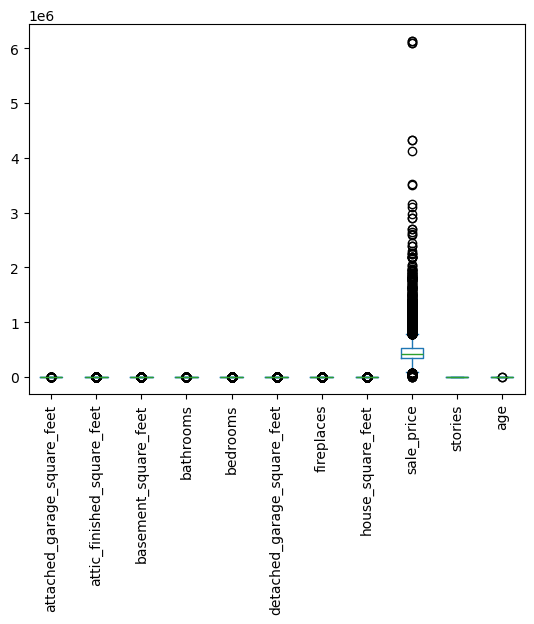

In [4]:
df.plot.box()
plt.xticks(rotation=90)  # Rotate x-axis labels 90 degrees
plt.show()

In [5]:
from sklearn.model_selection import train_test_split


df_train = df.iloc[:int(.8*df.shape[0]),:]
df_test = df.iloc[int(.8*df.shape[0]):,:]
y_test = df_test['sale_price']
X_test = df_test.drop('sale_price',axis=1)


def quick_tree(df,depth=15):
    # Resample and Process data:
    df_t = df_train.sample(n=df.shape[0],replace=True)
    y_train = df_t['sale_price']
    X_train = df_t.drop('sale_price',axis=1)
    # Fit decision tree:
    cart = tree.DecisionTreeRegressor(max_depth=depth, min_samples_leaf = 50) # Create a classifier object
    cart = cart.fit(X_train, y_train) # Fit the classifier
    # Visualize results:
    plt.figure(figsize=(10,10))
    tree.plot_tree(cart,feature_names=X_train.columns.to_list(),filled=True)
    plt.show()
    # Rsq:
    y_hat = cart.predict(X_test)
    SSE = np.sum( (y_test-y_hat)**2 )
    TSS = np.sum( (y_test-y_train.mean())**2 )
    Rsq = 1 - SSE/TSS
    print("R^2:", Rsq)
    return y_hat


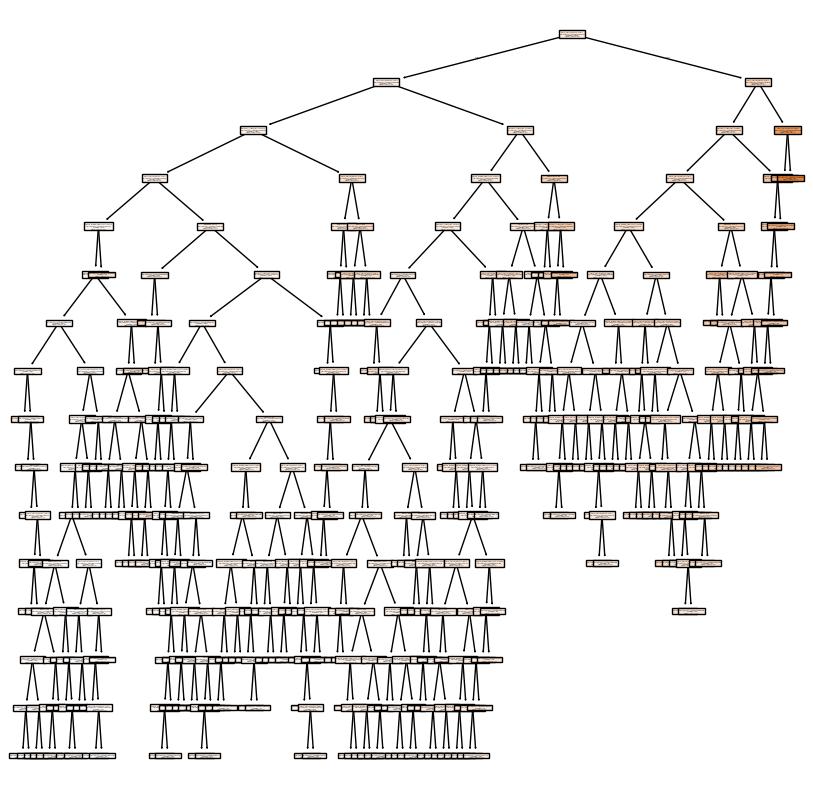

R^2: 0.34615828773474977


In [6]:
y_hat_1 = quick_tree(df)

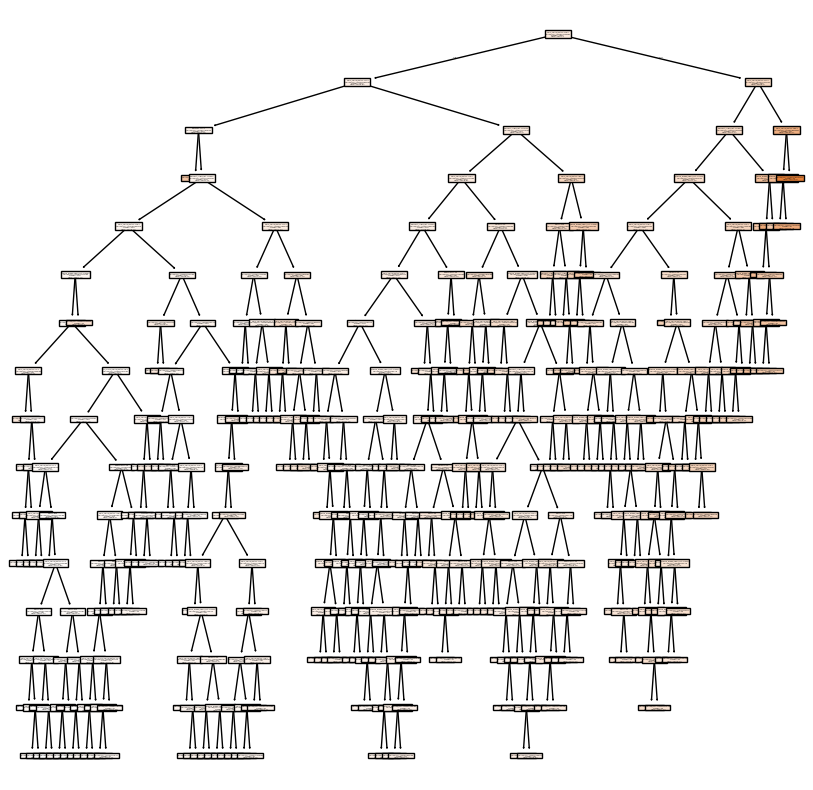

R^2: 0.34020373999519904


In [7]:
y_hat_2 = quick_tree(df)

- Maybe the predictions are similar?

<Axes: >

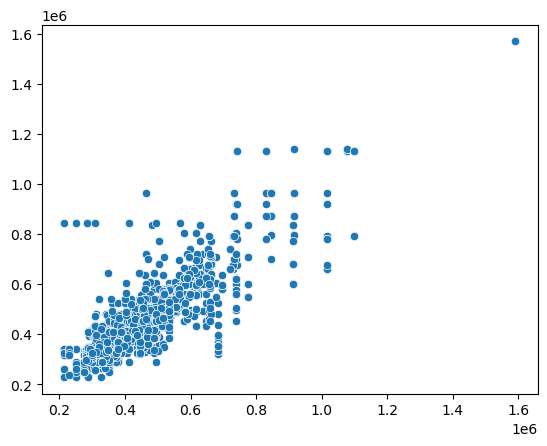

In [8]:
sns.scatterplot(x = y_hat_1, y = y_hat_2)

In [9]:
tdf = pd.DataFrame({'y_hat_1':y_hat_1, 'y_hat_2':y_hat_2})
tdf.corr()

,y_hat_1,y_hat_2
y_hat_1,1.000000,0.895332
y_hat_2,0.895332,1.000000


- These estimates are pretty similar, but also pretty different, even though the test set is the same

## An Example of Model Fragility
- This can be pretty bad: The predictor variables change, the cutpoints change... This doesn't look like it is capturing real, robust features of the data, and metrics like the $R^2$ are often all over the place on out-of-sample/testing/validation data
- We are picking on the decision tree because it is a particular offender, but **this is a concern for any model with hyperparameters to fit** (although linear models seem less susceptible to this problem, since their coefficients are just averages of sample values)
- It appears that the out-of-the-box decision tree is just a bit too sensitive to the underlying features of the data
- If this kind of bootstrap resampling reveals a problem with the decision tree model, maybe it also suggests a solution?

# Bootstrapping Our Models

## Ensembles and Bootstrap Aggregation
- We can easily take bootstrap samples of the original data and fit decision trees
- We can estimate a *set* of decision trees for a large number of bootstrap samples from the original data, called an **ensemble**, and then average them to get a predictor that is more robust
- This is called **bootstrap aggregation** or **bagging** or **model averaging**: We can take flawed models trained on random subsets of the data and combine them to improve overall performance
- The general name for this technique is **ensemble learning**
- Why? The WLLN implies convergence of averages, so let's average over models.

## Fitting an Ensemble
<!-- ![All Cause Mortality](./src/ensemble_construction.png)
![Ensembles](https://github.com/DS3001/ensembles/blob/main/ensemble_construction.jpeg?raw=1) -->

<div>
<img src="./src/ensemble_construction.jpeg" width="700"/>
</div>

## Predicting with an Ensemble

<div>
<img src="./src/ensemble_prediction.jpeg" width="700"/>
</div>

## Example of Ensemble Learning
- Let's predict the sale price of a home using an ensemble of decision trees
- We'll use 100 trees built on 100 random bootstrap samples of the original data
    - (This depends on the application, but we want it to run reasonably quickly for class purposes, so we'll constrain the max depth to a moderate value)
- Our goal is to compare the $R^2$ and variance of the individual trees versus the ensemble
- Some packages will automate this, but we'll do it "by hand" to be clear about how the idea is actually being implemented

In [10]:
# Split data into training rows and testing rows:
N = df.shape[0]
df = df.sample(frac=1, random_state=100) # randomize the order in which data appears
train_size = int(.8*N)
df_train = df[0:train_size]
N_train = df_train.shape[0]
df_test = df[train_size:]
N_test = df_test.shape[0]

df_train.head()

,attached_garage_square_feet,attic_finished_square_feet,basement_square_feet,bathrooms,bedrooms,detached_garage_square_feet,fireplaces,house_square_feet,sale_price,stories,age
13737,0,360,120,1,3,0,1,888,350000,1,79
16264,0,0,0,1,2,0,0,740,325000,1,103
15629,748,0,0,3,4,0,1,3081,840000,2,28
2430,0,0,0,2,3,0,0,1484,255000,2,26
4386,638,382,0,3,3,0,1,2232,705000,1,15


In [11]:
# Bootstrap:
T = 1000
m_depth = 10
Rsq = np.zeros(T) # preallocate the rsq measure
y_test_hat = np.zeros([T,N_test]) # preallocate predictions on test set

# Split data into train/test:
X_train = df_train.drop(['sale_price'],axis=1)
y_train = np.arcsinh(df_train['sale_price'])
X_test = df_test.drop(['sale_price'],axis=1)
y_test = np.arcsinh(df_test['sale_price'])

# Bootstrapping:
for s in range(T):
    # Generate a bootstrap sample:
    df_s = df_train.sample(frac=1, replace=True)
    X_s = df_s.drop('sale_price',axis=1)
    y_s = np.arcsinh(df_s['sale_price'])
    # Fit decision tree:
    cart = tree.DecisionTreeRegressor(max_depth=m_depth) # Create a classifier object
    cart = cart.fit(X_s, y_s) # Fit the classifier
    # Compute Rsq:
    y_hat = cart.predict(X_test)
    SSE = np.sum( (y_test-y_hat)**2 )
    TSS = np.sum( (y_test-y_s.mean())**2 )
    Rsq[s] = 1 - SSE/TSS
    # Make and Save Predictions:
    y_test_hat[s,:] = y_hat

# Ensemble predictor:
y_hat_ensemble = y_test_hat.mean(axis=0) # Average the columns to get the ensemble prediction
SSE = np.sum( (y_test-y_hat_ensemble)**2 )
TSS = np.sum( (y_test-y_train.mean())**2 )
Rsq_ensemble = 1 - SSE/TSS

print(Rsq_ensemble)

0.40567423660681


0.33714907448266385


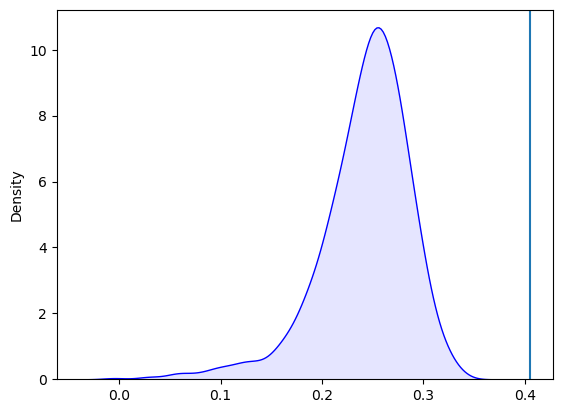

In [12]:
ax = sns.kdeplot(x = Rsq, fill = True, color = "blue", alpha = 0.1)
ax.axvline(x = Rsq_ensemble)

print(np.quantile(Rsq,1))

## Ensemble Advantage
- For inverse hyperbolic sine of sale price, the ensemble achieves an $R^2$ of .41 on the test set, and is better than any individual learner.
- More importantly, the ensemble predictor is **stable**: It is averaging over many draws of data, and because of the WLLN, adding more draws won't change its value a significant amount. We won't have a different predictor every day.
- This didn't require a "complicated" strategy, just a really clever one: Averaging models over our bootstrap resampling

## Ensemble versus Individual Learners
- *The performance of the ensemble average is not the average of ensemble performance*
- When we bootstrap, the ensemble performs even better: Higher accuracy overall and less variance than the individual learners
- A big payoff is a massive reduction in prediction variance: Without increasing bias, we're making much less noisy predictions overall
    - (This is one big payoff to learning about the LLN and bootstrapping: We're leveraging the power of the LLN to make higher quality predictions, and the bootstrap to evaluate the success)

## Ensemble versus Individual Learners
- This is a big step towards "fixing" decision trees, but you can use the principle of ensemble learning
- The intuition is, **each weak learner (tree) learns a bit of the true signal but also some noise; averaging many models that each capture a bit of signal keeps the signal and averages away the noise, resulting in a high quality model**

## Bagging ("Bootstrap Aggregation") and Classification
- We've assumed that we're doing regression and not classification: We averaged the predictions of each of the ensemble members to get an ensemble prediction, which only makes sense with regression
- When we're doing classification, we have each of the ensemble members "vote" on a category, and the category with the most votes from all the ensemble members wins

## Why stop there?
- Once you see this concept --- randomization can improve prediction algorithms by making them more robust --- you start noticing all kinds of places where data hiding or bootstrapping can be included
- Can we break the other decision tree problem: Over reliance on a small set of variables to the exclusion of many others?
- We'll also randomize which variables are offered to the decision tree algorithm for each bootstrap sample of the data at the time each split is made, to explore more nonlinear relationships between the features/predictor variables and target/outcome variable
- This leads to a powerful and popular tool: The Random Forest

# Random Forests

## Random Forests
- A **random forest** is constructed by:
  1. Select a bootstrap sample from the data
  2. Fit a decision tree as normal, but at each split in the tree, select a random subset of features/predictors/variables to consider (random subspace method)
  3. Repeat the above steps a large number of times
- To make a prediction, use all the trees in the forest and average the individual results for regression or take the most predicted category for classification
- This can be pretty computationally intensive (time to get a coffee or take a walk)

## Random Forests with `sklearn`


In [13]:
y_train.head()

13737    13.458836
16264    13.384728
15629    14.334304
2430     13.142166
4386     14.159100
Name: sale_price, dtype: float64

In [14]:
from sklearn.ensemble import RandomForestRegressor

# Fit model:
model = RandomForestRegressor(max_depth=10) # Build a random forest model
rf = model.fit(X_train,y_train) # Fit the rf model

# Make predictions:
y_hat_rf = rf.predict(X_test) # Model predictions

[Text(0.5, 1.0, 'Random Forest vs Test'),
 Text(0.5, 0, 'Test'),
 Text(0, 0.5, 'RF')]

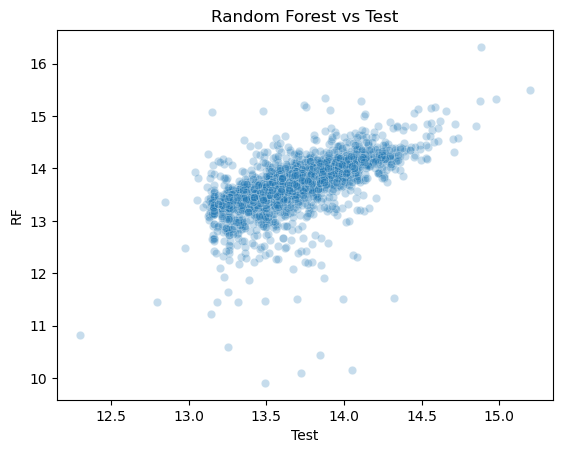

In [15]:
# Scatterplot of predicted v. actual:
import matplotlib.pyplot as plt
sns.scatterplot(y=y_test, x=y_hat_rf,alpha=.25).set(title='Random Forest vs Test', xlabel = 'Test', ylabel='RF') # Predicted v Actual

[Text(0.5, 1.0, 'Residuals')]

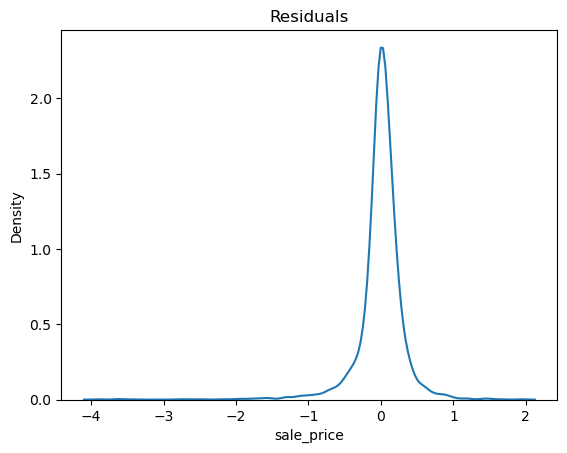

In [16]:
# Residual plot:
residual = y_test - y_hat_rf
sns.kdeplot(x=residual).set(title='Residuals')

In [17]:
print( 'Rsq: ', rf.score(X_test,y_test) ) # Rsq measure

Rsq:  0.40678301399161454


# Feature Importance

## Explainability, Interpretability
- We're reaching a point where the models become hard to explain to people and hard for us to interpret
- A model is **explainable** if the mapping from inputs to predictions can be understood by human intelligence (how does the model use inputs/data to create predictions?)
- A model is **interpretable** if any prediction can be rationalized from the data and model by human intelligence (why is the model making this particular prediction?)
- The random forest is the first model that probably isn't explainable or interpretable in these terms, since it aggregates many models trained on randomly generated subsets of data

## Variable Importance
- But our human minds prefer (demand?) interpretable output: A regression coefficient table, a dendrogram, etc.
- Since the random forest is an average of hundreds of randomly constructed objects, most of these interpretability tools are not useful
- Many times, people report **variable importance** as a way of suggesting which variables ended up being the most useful for the process of constructing the forest
    - It is the total amount by which Gini impurity/Entropy is reduced when this variable is used across all trees in the ensemble
- This is measured in impurity, **not** the impact on the predictions (like a regression coefficient)

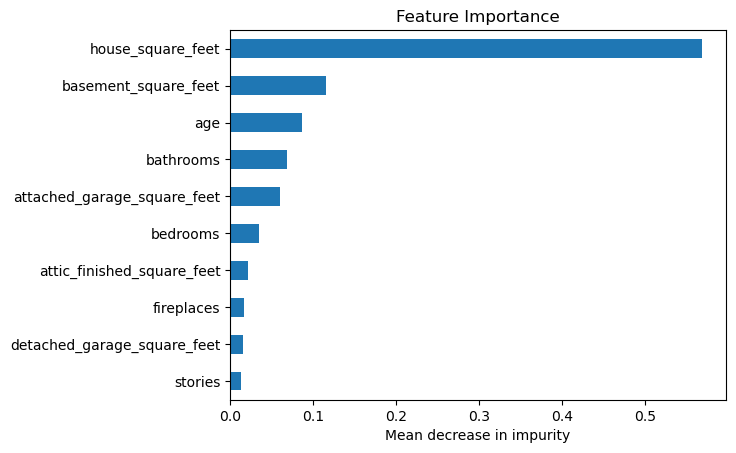

In [18]:
# Variable importance plot:
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns )
feature_importances.sort_values().plot(kind='barh')
plt.title('Feature Importance')
plt.xlabel('Mean decrease in impurity')
plt.show()

# Classification

## Classification
- We've focused on regression, but you can obviously do this with classification
- Instead of predicting a numeric value, each weak learner (tree) predicts a categorical value
- The weak learners "vote" over the winning prediction: The label with the most votes wins (or, you can report the frequency of the votes)
- Our example will be predicting bond ratings from information about the company

In [19]:
import numpy as np
import pandas as pd

df = pd.read_csv('./data/corporate_ratings.csv')
print(df.shape)
df.head()

(2029, 31)


,Rating,Name,Symbol,Rating Agency Name,Date,Sector,currentRatio,quickRatio,cashRatio,daysOfSalesOutstanding,...,effectiveTaxRate,freeCashFlowOperatingCashFlowRatio,freeCashFlowPerShare,cashPerShare,companyEquityMultiplier,ebitPerRevenue,enterpriseValueMultiple,operatingCashFlowPerShare,operatingCashFlowSalesRatio,payablesTurnover
0,A,Whirlpool Corporation,WHR,Egan-Jones Ratings Company,11/27/2015,Consumer Durables,0.945894,0.426395,0.099690,44.203245,...,0.202716,0.437551,6.810673,9.809403,4.008012,0.049351,7.057088,15.565438,0.058638,3.906655
1,BBB,Whirlpool Corporation,WHR,Egan-Jones Ratings Company,2/13/2014,Consumer Durables,1.033559,0.498234,0.203120,38.991156,...,0.074155,0.541997,8.625473,17.402270,3.156783,0.048857,6.460618,15.914250,0.067239,4.002846
2,BBB,Whirlpool Corporation,WHR,Fitch Ratings,3/6/2015,Consumer Durables,0.963703,0.451505,0.122099,50.841385,...,0.214529,0.513185,9.693487,13.103448,4.094575,0.044334,10.491970,18.888889,0.074426,3.483510
3,BBB,Whirlpool Corporation,WHR,Fitch Ratings,6/15/2012,Consumer Durables,1.019851,0.510402,0.176116,41.161738,...,1.816667,-0.147170,-1.015625,14.440104,3.630950,-0.012858,4.080741,6.901042,0.028394,4.581150
4,BBB,Whirlpool Corporation,WHR,Standard & Poor's Ratings Services,10/24/2016,Consumer Durables,0.957844,0.495432,0.141608,47.761126,...,0.166966,0.451372,7.135348,14.257556,4.012780,0.053770,8.293505,15.808147,0.058065,3.857790


Rating
BBB    671
BB     490
A      398
B      302
AA      89
CCC     64
AAA      7
CC       5
C        2
D        1
Name: count, dtype: int64


<Axes: >

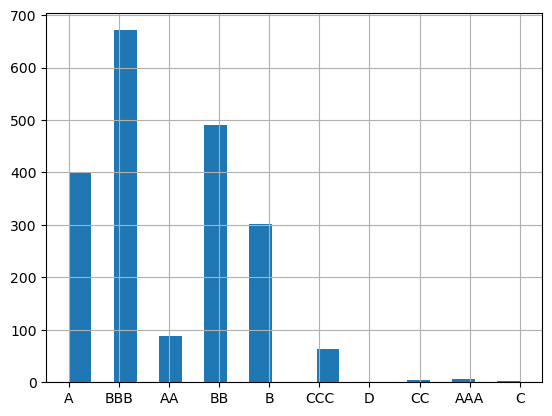

In [20]:
print(df['Rating'].value_counts())
df['Rating'].hist(bins=20)

In [21]:
from sklearn.model_selection import train_test_split

y = df['Rating']
X = df.drop(['Rating','Date','Name','Symbol','Rating Agency Name','Sector'],axis=1)

sector = pd.get_dummies(df['Sector'],dtype=int)
agency = pd.get_dummies(df['Rating Agency Name'],dtype=int)
X = pd.concat([X,agency,sector],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,
                                                    random_state=100)

In [22]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(min_samples_leaf = 35, max_depth = 15) # No pruning
rf.fit(X_train, y_train) # Fit the classifier
y_hat = rf.predict(X_test)

print(pd.crosstab(y_test,y_hat))

acc = np.trace(pd.crosstab(y_test,y_hat))/len(y_test)
print(acc)


col_0    A   B  BB  BBB
Rating                 
A       29   0   3   59
AA      10   0   1    8
AAA      1   0   0    0
B        0  24  26   20
BB       4  13  41   42
BBB      8   3  14   90
CCC      0   3   5    1
D        0   0   0    1
0.1206896551724138


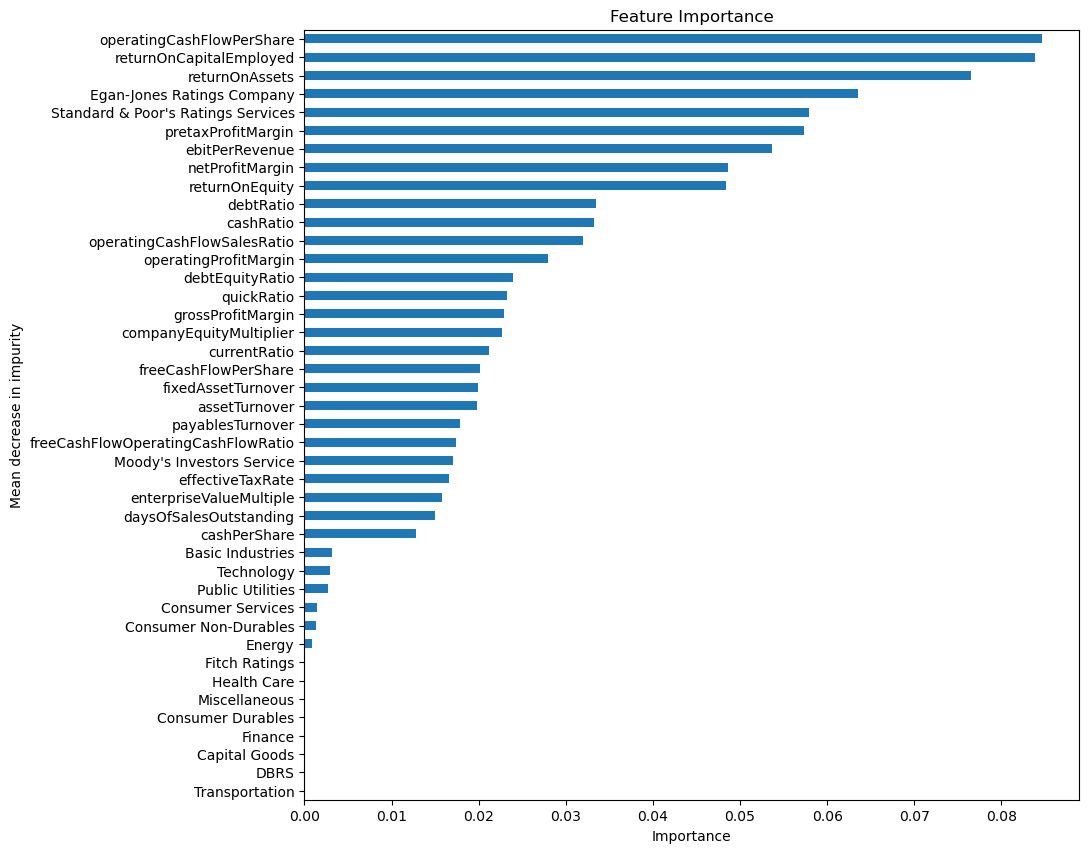

In [23]:
plt.figure(figsize=(10,10))
# Variable importance plot:
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns )
feature_importances.sort_values().plot(kind='barh')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Mean decrease in impurity')
plt.show()

- What if we drop the identity of the rating services? Why is that important?

In [24]:
y = df['Rating']
X = df.drop(['Rating','Date','Name','Symbol','Rating Agency Name','Sector'],axis=1)

sector = pd.get_dummies(df['Sector'],dtype=int)
X = pd.concat([X,sector],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,
                                                    random_state=100)

In [25]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(min_samples_leaf = 35, max_depth = 15) # No pruning
rf.fit(X_train, y_train) # Fit the classifier
y_hat = rf.predict(X_test)

print(pd.crosstab(y_test,y_hat))

acc = np.trace(pd.crosstab(y_test,y_hat))/len(y_test)
print(acc)


col_0    A   B  BB  BBB
Rating                 
A       20   0   7   64
AA       5   0   1   13
AAA      0   0   0    1
B        1  26  24   19
BB       3  16  32   49
BBB      3   3  12   97
CCC      0   4   3    2
D        0   0   0    1
0.0960591133004926


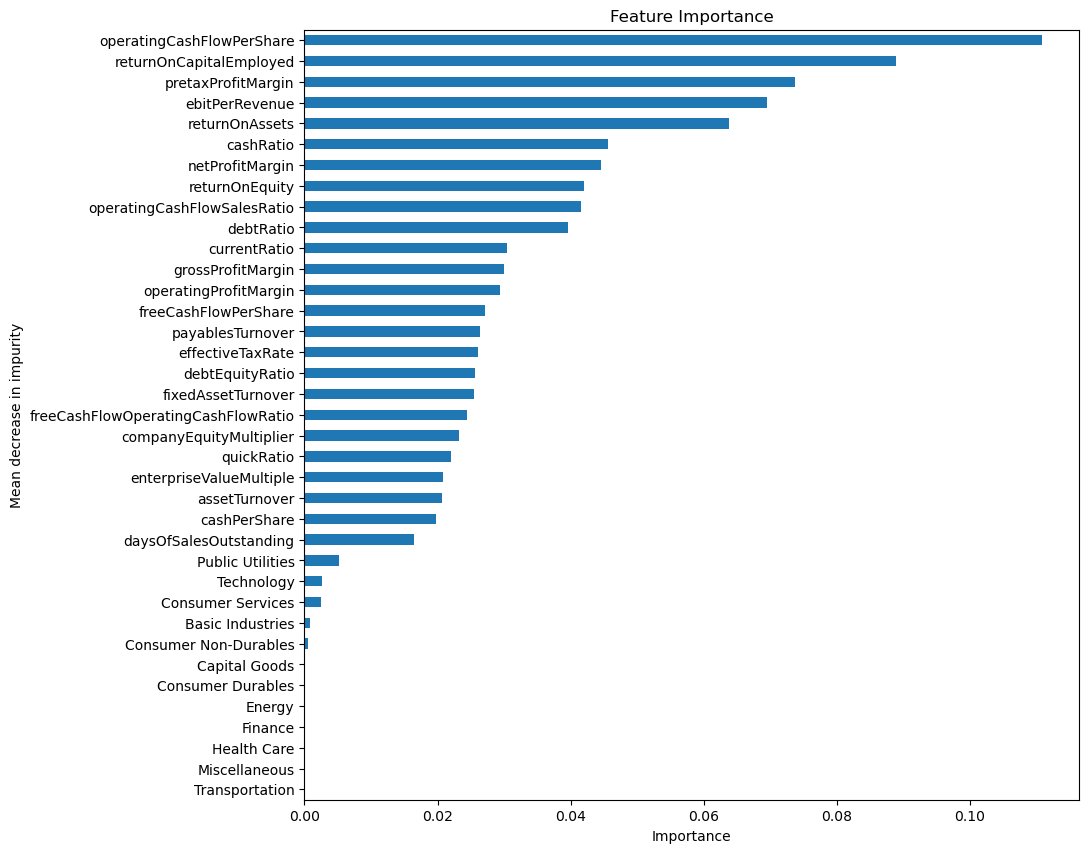

In [26]:
plt.figure(figsize=(10,10))
# Variable importance plot:
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns )
feature_importances.sort_values().plot(kind='barh')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Mean decrease in impurity')
plt.show()

- So the rating agency accounts for 3% of the accuracy
- What are possible explanations? Seems odd, at best.

# Conclusion

## Ensembles
- Ensemble learning can improve the performance of any kind of base learner (e.g. decision trees, linear models) through "bootstrap aggregation" (model averaging)
- These ideas can also motivate more complex uses of randomization to improve performance: The intuition is to make the ensemble members as uncorrelated as possible, but still trained on the same data, so their different predictions end up complementing one another
- The Random Forest is a complex and computationally intensive algorithm, but it resolves the fragility problem for decision-trees by using bootstrap aggregation and random feature selection
- This is the first payoff of adopting a more probabilistic perspective on the data